In [9]:
import scipy.io
import pandas as pd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import torch

import pandas as pd

import cv2 
import numpy as np 

import os
import random
import pickle
import keras.preprocessing.image as kimg

In [2]:
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mat = scipy.io.loadmat('./data/wiki_crop/wiki.mat')

In [4]:

instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", 'date_of_birth']
 

df = pd.DataFrame(index = range(0,instances), columns = columns)

for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
    
        for j in range(len(current_array)):
            
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [5]:
def calculate_age(dob):
    '''
    Calculates age given
    the date of birth.
    
    Parameter
    ---------
    dob : date of birth
    '''
    birth = datetime.fromordinal(max(int(dob) - 366, 1))
    if birth.month < 7:
        return birth.year
    else:
        return birth.year + 1

df['date_of_birth'] = df['dob'].apply(calculate_age)

In [6]:
#Data cleaning
df=df[~df['date_of_birth'].isna()]
#calculate age
df['age']=df['photo_taken']-df['date_of_birth']
df=df[~df['gender'].isna()]
df=df[df['second_face_score'].isna()]
df=df[df['face_score']>=3]
df=df.drop(columns= ["name", "face_location", "face_score", "second_face_score",'date_of_birth' ])
df=df[df['age']<=100]
df=df[df['age']>0]

df.shape[0]

22138

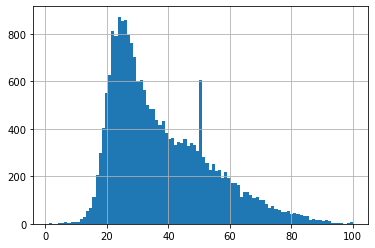

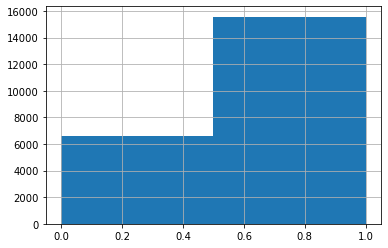

In [8]:
hist_age=df['age'].hist(bins=df['age'].nunique())
plt.show()
hist_gender=df['gender'].hist(bins=df['gender'].nunique())

In [ ]:
target_size = (224, 224)
df=df.iloc[:10]
def getImagePixels(image_path):
    img = kimg.load_img("./data/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = kimg.img_to_array(img).reshape(1, -1)[0]

    
    return x

In [ ]:
df['features'] = df['full_path'].apply(getImagePixels)

In [10]:
f=torch.from_numpy(df['features'].values)
f=f.view(df.shape[0],224,224,3)
torch.save(f, "features.pt")

In [8]:
classes=101
target=torch.from_numpy(df['age'].values)
torch.save(target, "age.pt")
target_gen=torch.from_numpy(df['gender'].values)
torch.save(target_gen, "gender.pt")
del df